<a href="https://colab.research.google.com/github/AmaniHassan1/Model4-MobileNetV2/blob/main/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions 
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')

kaggle.json


In [2]:
# Download data
!pip install -q kaggle
!kaggle datasets download -d hereisburak/pins-face-recognition

 96% 357M/372M [00:02<00:00, 174MB/s]
100% 372M/372M [00:02<00:00, 167MB/s]


In [3]:
!unzip '/content/pins-face-recognition.zip' -d '/content/dataset/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner37_964.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner38_965.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner39_966.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner3_956.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner41_968.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner42_969.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner44_970.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner45_971.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner46_972.jpg  
  inflating: /content/dataset/105_classes_pins_dat

In [4]:
!pip install keras_applications
!pip install keras_squeezenet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 2.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras_squeezenet: filename=keras_squeezenet-0.4-py3-none-any.whl size=3589 sha256=7873973ab71b663ae9726db6d0d80dc8fe5c62c103e33b800d11a5b49e35b88d
  Stored in directory: /root/.cache/pip/wheels/cd/df/21/37c89f005cc3673147e796e276170acb854c202d7e00e7a011
Successfully built keras_squeezenet


In [5]:
import os
import gc
import sys

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import skimage
from skimage.feature import greycomatrix, greycoprops
from skimage.filters import sobel
from skimage import color

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras import layers
import keras.backend as K
from tensorflow.keras.models import Sequential, Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization, Conv2D,AvgPool2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, ZeroPadding2D, Convolution2D
from tensorflow.keras.layers import ReLU, DepthwiseConv2D, Reshape, Permute, MaxPool2D, concatenate, Add
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import get_file 

from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.applications import MobileNetV2

from shutil import copyfile
from PIL import Image
from tqdm import tqdm
import random as rnd
import cv2
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

pd.set_option('display.max_colwidth', -1)

!pip install livelossplot
from livelossplot import PlotLossesKeras

%matplotlib inline

<ipython-input-5-7131387a9641>:45: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
input_path = '/content/dataset/105_classes_pins_dataset'

In [7]:
celebrity_images = os.listdir('/content/dataset/105_classes_pins_dataset')

In [8]:
images = []
classes = []
paths = []
for dirs in celebrity_images:
    images_ = os.listdir(input_path+'/'+dirs)
    for image in images_:
        images.append(image)
        paths.append(input_path+'/'+dirs+'/'+image)
        classes.append(dirs)

In [9]:
train_df = pd.DataFrame()
train_df['paths'] = paths
train_df['classes'] = classes
train_df['images'] = images

In [10]:
train_df.head()

paths  \
0  /content/dataset/105_classes_pins_dataset/pins_Elizabeth Lail/Elizabeth Lail36_1158.jpg    
1  /content/dataset/105_classes_pins_dataset/pins_Elizabeth Lail/Elizabeth Lail120_1072.jpg   
2  /content/dataset/105_classes_pins_dataset/pins_Elizabeth Lail/Elizabeth Lail179_1108.jpg   
3  /content/dataset/105_classes_pins_dataset/pins_Elizabeth Lail/Elizabeth Lail201_1122.jpg   
4  /content/dataset/105_classes_pins_dataset/pins_Elizabeth Lail/Elizabeth Lail107_1058.jpg   

               classes                      images  
0  pins_Elizabeth Lail  Elizabeth Lail36_1158.jpg   
1  pins_Elizabeth Lail  Elizabeth Lail120_1072.jpg  
2  pins_Elizabeth Lail  Elizabeth Lail179_1108.jpg  
3  pins_Elizabeth Lail  Elizabeth Lail201_1122.jpg  
4  pins_Elizabeth Lail  Elizabeth Lail107_1058.jpg

In [11]:
train_df.count()

paths      17534
classes    17534
images     17534
dtype: int64

In [12]:
print('Train samples count: ', len(train_df))
train_df.columns

Train samples count:  17534


Index(['paths', 'classes', 'images'], dtype='object')

In [13]:
print('Class Count: ',len(train_df['classes'].value_counts()))
train_df['classes'].value_counts()

Class Count:  105


pins_Leonardo DiCaprio     237
pins_Robert Downey Jr      233
pins_Katherine Langford    226
pins_Alexandra Daddario    225
pins_elizabeth olsen       221
                          ... 
pins_Morgan Freeman        105
pins_Brian J. Smith        102
pins_Cristiano Ronaldo     98 
pins_Mark Zuckerberg       95 
pins_Lionel Messi          86 
Name: classes, Length: 105, dtype: int64

In [14]:
train_df.isna().sum()

paths      0
classes    0
images     0
dtype: int64

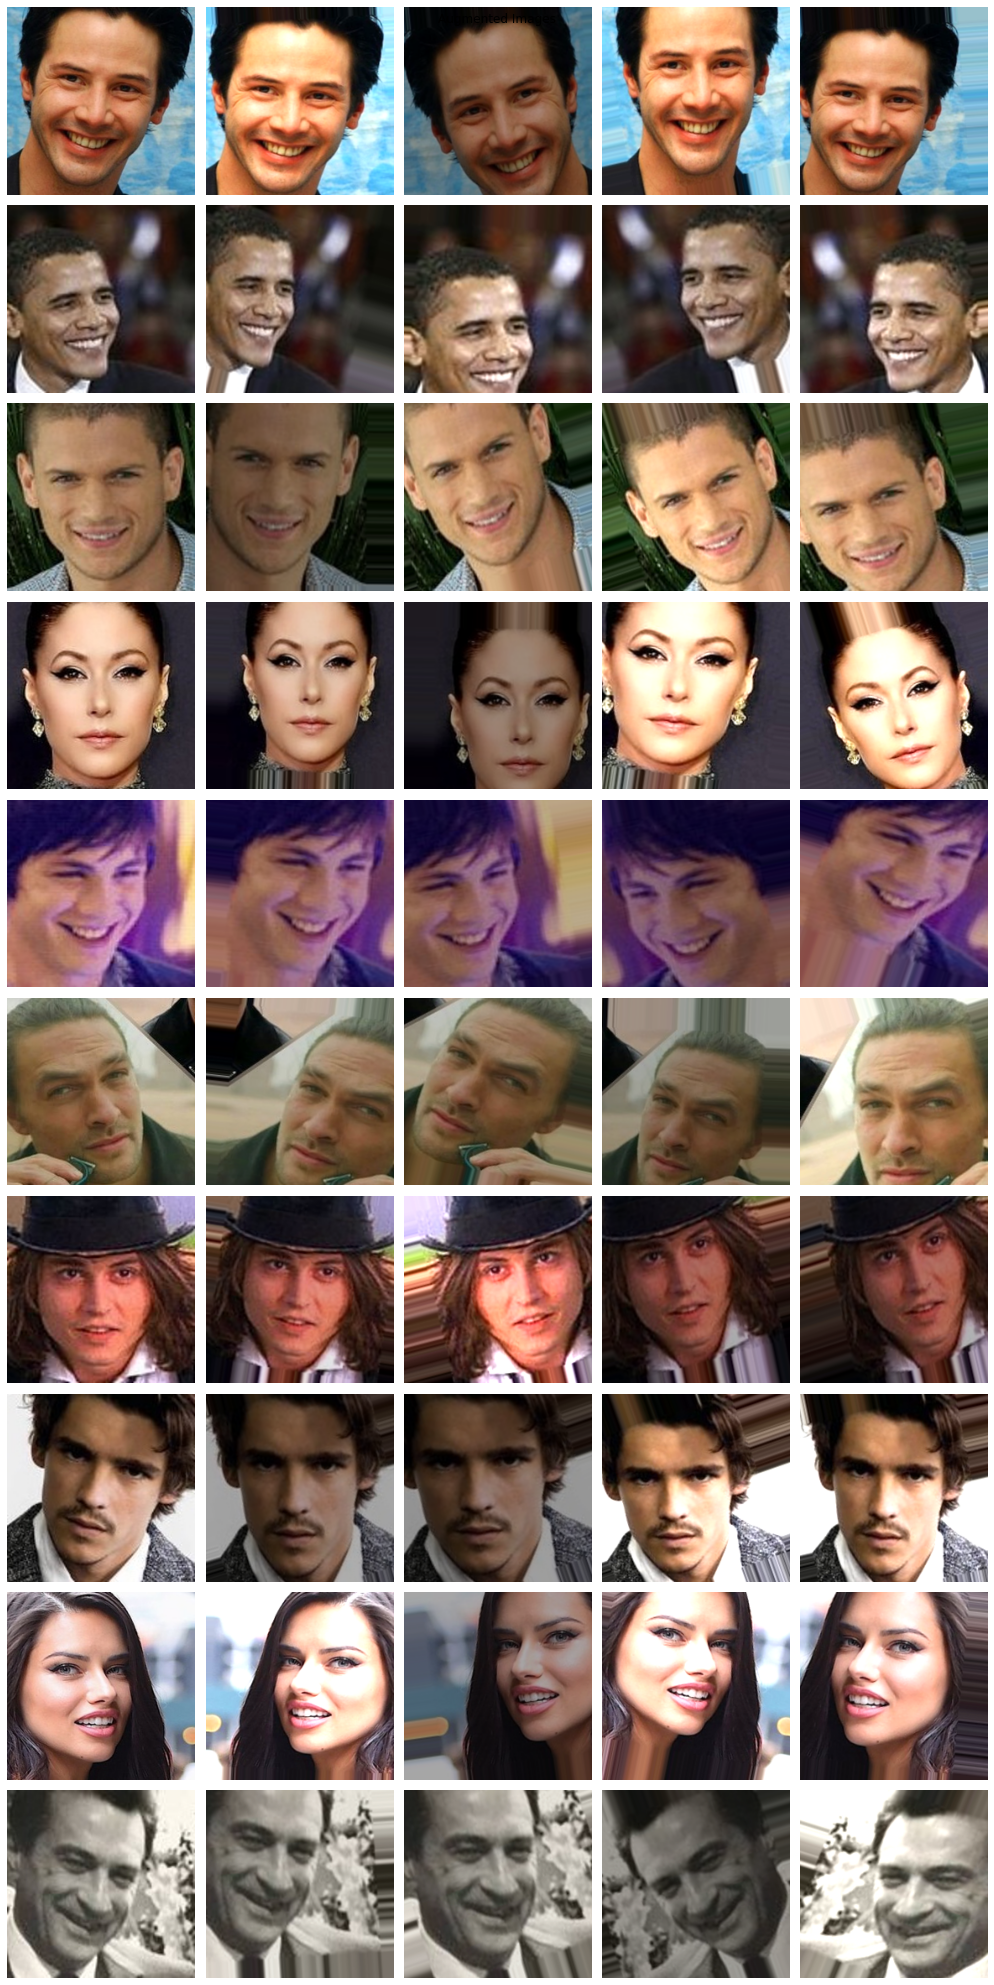

In [15]:
def plot_augimages(paths, datagen):
    plt.figure(figsize = (14,28))
    plt.suptitle('Augmented Images')
    
    midx = 0
    for path in paths:
        data = Image.open(path)
        data = data.resize((224,224))
        samples = expand_dims(data, 0)
        it = datagen.flow(samples, batch_size=1)
    
        # Show Original Image
        plt.subplot(10,5, midx+1)
        plt.imshow(data)
        plt.axis('off')
    
        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            midx += 1
            plt.subplot(10,5, midx+1)
            
            batch = it.next()
            image = batch[0].astype('uint8')
            plt.imshow(image)
            plt.axis('off')
        midx += 1
    
    plt.tight_layout()
    plt.show()

    
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
) 
plot_augimages(np.random.choice(train_df['paths'],10), datagen)

In [16]:
y_count=len(train_df['classes'].unique())

In [17]:
trained_model=MobileNetV2(input_shape=(160,160,3),           
                    include_top=False,
                    weights='imagenet')   


trained_model.trainable=True  #Un-Freeze all the pretrained layers of 'MobileNetV2 for Training.
    
last_layer=trained_model.get_layer('out_relu')   
last_layer_output=last_layer.output 
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
x = tf.keras.layers.Dropout(0.8)(x) 
x = Dense(120)(x)
output = Dense(y_count,activation="softmax")(x)
model_mobilenet = Model(trained_model.input,output)

9406464/9406464 [==============================] - 0s 0us/step


In [18]:
model_mobilenet.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
rlrp_mobilenet = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=2,verbose=2,mode="auto",min_delta=0.0001,cooldown=0,min_lr=0)

In [19]:
X=train_df[['paths', 'classes', 'images']]
y=train_df[['classes']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
mobilenet_datagen_train = ImageDataGenerator(rescale=1/255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)
mobilenet_datagen_test = ImageDataGenerator(rescale=1/255)

In [21]:
train_generator_mobilenet = mobilenet_datagen_train.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='paths',
        y_col='classes',
        target_size=(160,160),  # All images will be resized to 160x160
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 14027 validated image filenames belonging to 105 classes.


In [22]:
val_generator_mobilenet = mobilenet_datagen_test.flow_from_dataframe(
        X_test,  # This is the source directory for training images
        x_col='paths',
        y_col='classes',
        target_size=(160, 160),  # All images will be resized to 160x160
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 3507 validated image filenames belonging to 105 classes.


In [23]:
history_mobilenet = model_mobilenet.fit(
      train_generator_mobilenet,
     validation_data=val_generator_mobilenet,
    callbacks=[rlrp_mobilenet],
      epochs=40,
      verbose=1)

Epoch 1/40
439/439 [==============================] - 133s 221ms/step - loss: 5.0116 - accuracy: 0.0142 - val_loss: 4.6988 - val_accuracy: 0.0188 - lr: 1.0000e-04
Epoch 2/40
439/439 [==============================] - 96s 218ms/step - loss: 4.5248 - accuracy: 0.0299 - val_loss: 4.4828 - val_accuracy: 0.0308 - lr: 1.0000e-04
Epoch 3/40
439/439 [==============================] - 96s 218ms/step - loss: 4.1999 - accuracy: 0.0573 - val_loss: 4.1001 - val_accuracy: 0.0602 - lr: 1.0000e-04
Epoch 4/40
439/439 [==============================] - 96s 217ms/step - loss: 3.7330 - accuracy: 0.1147 - val_loss: 3.4521 - val_accuracy: 0.1637 - lr: 1.0000e-04
Epoch 5/40
439/439 [==============================] - 95s 217ms/step - loss: 3.2630 - accuracy: 0.1874 - val_loss: 3.3411 - val_accuracy: 0.1796 - lr: 1.0000e-04
Epoch 6/40
439/439 [==============================] - 96s 217ms/step - loss: 2.8338 - accuracy: 0.2750 - val_loss: 2.5494 - val_accuracy: 0.3396 - lr: 1.0000e-04
Epoch 7/40
439/439 [=======

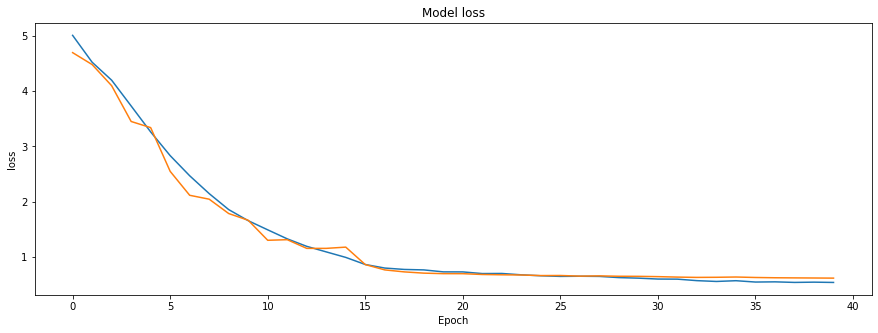

In [24]:
plt.figure(figsize=(15,5))
plt.plot(history_mobilenet.history['loss'])
plt.plot(history_mobilenet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

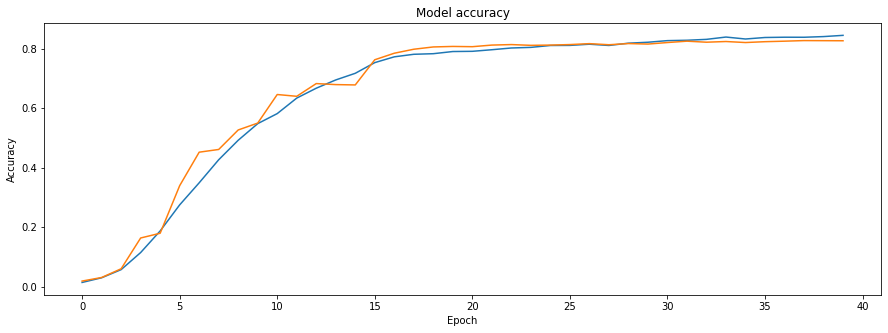

In [25]:
plt.figure(figsize=(15,5))
plt.plot(history_mobilenet.history['accuracy'])
plt.plot(history_mobilenet.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()